# Analysis 1 Judge_Experience
---

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

## Preprocessing : 

In [ ]:
df_judges = pd.read_csv("./precog_data/csv/judges_clean.csv")
df_merge_key = pd.read_csv("./precog_data/csv/keys/judge_case_merge_key.csv")
df_disp = pd.read_csv("./precog_data/csv/keys/disp_name_key.csv")

columns_judge = ["ddl_judge_id","state_code","dist_code","court_no","judge_position","female_judge","start_date","end_date"] 
df_judges.columns = columns_judge

In [ ]:
case_years = [
    "./precog_data/csv/cases/cases_2010.csv",
    "./precog_data/csv/cases/cases_2011.csv", 
    "./precog_data/csv/cases/cases_2012.csv", 
    "./precog_data/csv/cases/cases_2013.csv", 
    "./precog_data/csv/cases/cases_2014.csv", 
    "./precog_data/csv/cases/cases_2015.csv", 
    "./precog_data/csv/cases/cases_2016.csv", 
    "./precog_data/csv/cases/cases_2017.csv", 
    "./precog_data/csv/cases/cases_2018.csv", ]

In [ ]:
df_judges_merged = pd.merge(
    left= df_merge_key, 
    right= df_judges, 
    left_on="ddl_decision_judge_id", 
    right_on="ddl_judge_id",
    how="inner")

---
### Calculating the average age of judges making a decision, and also splitting the judges into quartiles of experience (the number of days of experience a judge needs to have to fall in a certain class of experience). The quartiles are split so that the number of judges in each class stay the same to ensure conclusions drawn are not skewed.

In [ ]:
def calculate_exp(a, b): # helper function to calculate the experience
    # distance between the smaller a, and the bigger b date
    
    date_object_2 = datetime.strptime(str(a), '%d-%m-%Y').date()
    date_object_1 = datetime.strptime(str(b), '%Y-%m-%d').date()
        
    return int((date_object_1 - date_object_2).days)

In [ ]:
average_age_decision = [] # will store quartile tuples of each year
for case_year in case_years:
    
    chunk_counter = 0
    quartile_1_acc = 0
    quartile_2_acc = 0
    quartile_3_acc = 0 
    
    # using mean of means to calculate quartiles
    
    case_iterator = pd.read_csv(case_year, chunksize=100000, iterator = True)
    for case_df in case_iterator:
        
        df_merged_cases = pd.merge(
            left= df_judges_merged, 
            right= case_df, 
            on = "ddl_case_id",
            how="inner")

        df_merged_disp = pd.merge(
            left = df_merged_cases,
            right = df_disp,
            on = "disp_name",
            how="inner"
        )

        # at this point, we merged the judge, the case chunk, and the disposition using an inner join

        df_merged_disp = df_merged_disp[df_merged_disp['date_of_filing'].notna()]
        df_merged_disp = df_merged_disp[df_merged_disp['disp_name_s'].notna()]
        df_merged_disp = df_merged_disp[df_merged_disp['start_date'].notna()]
        df_merged_disp = df_merged_disp[df_merged_disp['date_of_decision'].notna()]
        
        if df_merged_disp.shape[0] > 0:

            df_merged_disp["exp_when_decision"] = df_merged_disp.apply(lambda row: calculate_exp(row["start_date"],
                                                                                                 row["date_of_decision"]),axis=1)
            df_merged_disp = df_merged_disp[df_merged_disp["exp_when_decision"] >= 0]

            quartile_1_acc += df_merged_disp["exp_when_decision"].describe()["25%"]
            quartile_2_acc += df_merged_disp["exp_when_decision"].describe()["50%"]
            quartile_3_acc += df_merged_disp["exp_when_decision"].describe()["75%"]        
        chunk_counter += 1
        print(quartile_1_acc / chunk_counter,quartile_2_acc / chunk_counter,quartile_3_acc / chunk_counter)
    average_age_decision.append((quartile_1_acc / chunk_counter,quartile_2_acc / chunk_counter,quartile_3_acc / chunk_counter))

In [5]:
plt_x_average_exp = ["2010","2011","2012","2013","2014","2015","2016","2017","2018"]
plt_y_average_exp = []
for i in average_age_decision:
    plt_y_average_exp.append(i[0]/3 + i[1]/3 + i[2]/3)

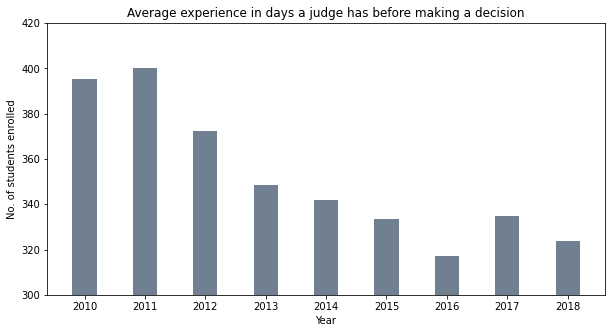

In [6]:
fig = plt.figure(figsize = (10, 5))
plt.bar(plt_x_average_exp, plt_y_average_exp, color ='slategrey',
        width = 0.4)
 
plt.xlabel("Year")
plt.ylabel("No. of students enrolled")
plt.title("Average experience in days a judge has before making a decision")
plt.ylim(300)
plt.show()

### *This shows that the average experience of a judge making a decision has been consistently going down, that is, judges are on average less experienced while making a decision over the years.*
---
### Now we find judge quartile ranges over 5 disposition types : [bail, convicted, confession, plead_guilty, bail_order] since basic data exploration lead to showing some statistical significance in these outputs.

In [ ]:
def assign_exp(exp, q1, q2, q3): # helper function to return quartile pertaining to that year
    if exp < q1:
        return "noobie"
    elif exp >= q1 and exp < q2:
        return "beginner"
    elif exp >= q2 and exp < q3:
        return "intermediate"
    else: return "advanced"

In [ ]:
%%time
arr_bail_refused = []
arr_convicted = []
arr_confession = []
arr_plead_guilty = []
arr_bail_order = []

idx = 0

for case_year in case_years:
    
    bail_refused_list = [0,0,0,0]
    convicted_list = [0,0,0,0]
    confession_list = [0,0,0,0]
    plead_list = [0,0,0,0]
    bail_order_list = [0,0,0,0]

    cases_df = pd.read_csv(case_year, chunksize = 1000000, iterator=True)
    for case_df in cases_df:
        df_merged_cases = pd.merge(
            left= df_judges_merged, 
            right= case_df, 
            on = "ddl_case_id",
            how="inner"
        )

        df_merged_disp = pd.merge(
            left = df_merged_cases,
            right = df_disp,
            on = "disp_name",
            how="inner"
        )
        
        df_merged_disp = df_merged_disp[df_merged_disp['date_of_filing'].notna()]
        df_merged_disp = df_merged_disp[df_merged_disp['disp_name_s'].notna()]
        df_merged_disp = df_merged_disp[df_merged_disp['start_date'].notna()]
        df_merged_disp = df_merged_disp[df_merged_disp['date_of_decision'].notna()]
        
        if df_merged_disp.shape[0] > 0:
            df_merged_disp["exp_when_decision"] = df_merged_disp.apply(lambda row: calculate_exp(row["start_date"],
                                                                                                 row["date_of_decision"]),axis=1)
            df_merged_disp = df_merged_disp[df_merged_disp["exp_when_decision"] >= 0]
            
        df_merged_disp["exp_level"] = df_merged_disp.apply(lambda row: assign_exp(row["exp_when_decision"], 
                                                                                  average_age_decision[idx][0], 
                                                                                  average_age_decision[idx][1], 
                                                                                  average_age_decision[idx][2]), axis = 1)
        
        # out of all the cases that have {some_disposition}, how many by quartile
        
        df_temp_1 = df_merged_disp[df_merged_disp["disp_name_s"] == "bail refused"]
        df_temp_2 = df_merged_disp[df_merged_disp["disp_name_s"] == "convicted"]
        df_temp_3 = df_merged_disp[df_merged_disp["disp_name_s"] == "confession"]
        df_temp_4 = df_merged_disp[df_merged_disp["disp_name_s"] == "plead guilty"]
        df_temp_5 = df_merged_disp[df_merged_disp["disp_name_s"] == "bail order"]
        
        bail_refused_list[0] += df_temp_1[df_temp_1["exp_level"] == "noobie"].shape[0]
        bail_refused_list[1] += df_temp_1[df_temp_1["exp_level"] == "beginner"].shape[0]
        bail_refused_list[2] += df_temp_1[df_temp_1["exp_level"] == "intermediate"].shape[0]
        bail_refused_list[3] += df_temp_1[df_temp_1["exp_level"] == "advanced"].shape[0]
        convicted_list[0] += df_temp_2[df_temp_2["exp_level"] == "noobie"].shape[0]
        convicted_list[1] += df_temp_2[df_temp_2["exp_level"] == "beginner"].shape[0]
        convicted_list[2] += df_temp_2[df_temp_2["exp_level"] == "intermediate"].shape[0]
        convicted_list[3] += df_temp_2[df_temp_2["exp_level"] == "advanced"].shape[0]
        confession_list[0] += df_temp_3[df_temp_3["exp_level"] == "noobie"].shape[0]
        confession_list[1] += df_temp_3[df_temp_3["exp_level"] == "beginner"].shape[0]
        confession_list[2] += df_temp_3[df_temp_3["exp_level"] == "intermediate"].shape[0]
        confession_list[3] += df_temp_3[df_temp_3["exp_level"] == "advanced"].shape[0]
        plead_list[0] += df_temp_4[df_temp_4["exp_level"] == "noobie"].shape[0]
        plead_list[1] += df_temp_4[df_temp_4["exp_level"] == "beginner"].shape[0]
        plead_list[2] += df_temp_4[df_temp_4["exp_level"] == "intermediate"].shape[0]
        plead_list[3] += df_temp_4[df_temp_4["exp_level"] == "advanced"].shape[0]
        bail_order_list[0] += df_temp_5[df_temp_5["exp_level"] == "noobie"].shape[0]
        bail_order_list[1] += df_temp_5[df_temp_5["exp_level"] == "beginner"].shape[0]
        bail_order_list[2] += df_temp_5[df_temp_5["exp_level"] == "intermediate"].shape[0]
        bail_order_list[3] += df_temp_5[df_temp_5["exp_level"] == "advanced"].shape[0]
        
    
    arr_bail_refused.append(bail_refused_list)
    arr_convicted.append(convicted_list)
    arr_confession.append(confession_list)
    arr_plead_guilty.append(plead_list)
    arr_bail_order.append(bail_order_list)
    
    idx += 1

In [8]:
arr_convicted_np = np.asarray(arr_convicted)
arr_convicted_np = arr_convicted_np.transpose()

arr_confession_np = np.asarray(arr_confession)
arr_confession_np = arr_confession_np.transpose()

arr_bail_refused_np = np.asarray(arr_bail_refused)
arr_bail_refused_np = arr_bail_refused_np.transpose()

arr_plead_guilty_np = np.asarray(arr_plead_guilty)
arr_plead_guilty_np = arr_plead_guilty_np.transpose()

Text(0.5, 1.0, 'Cases with confession disposition')

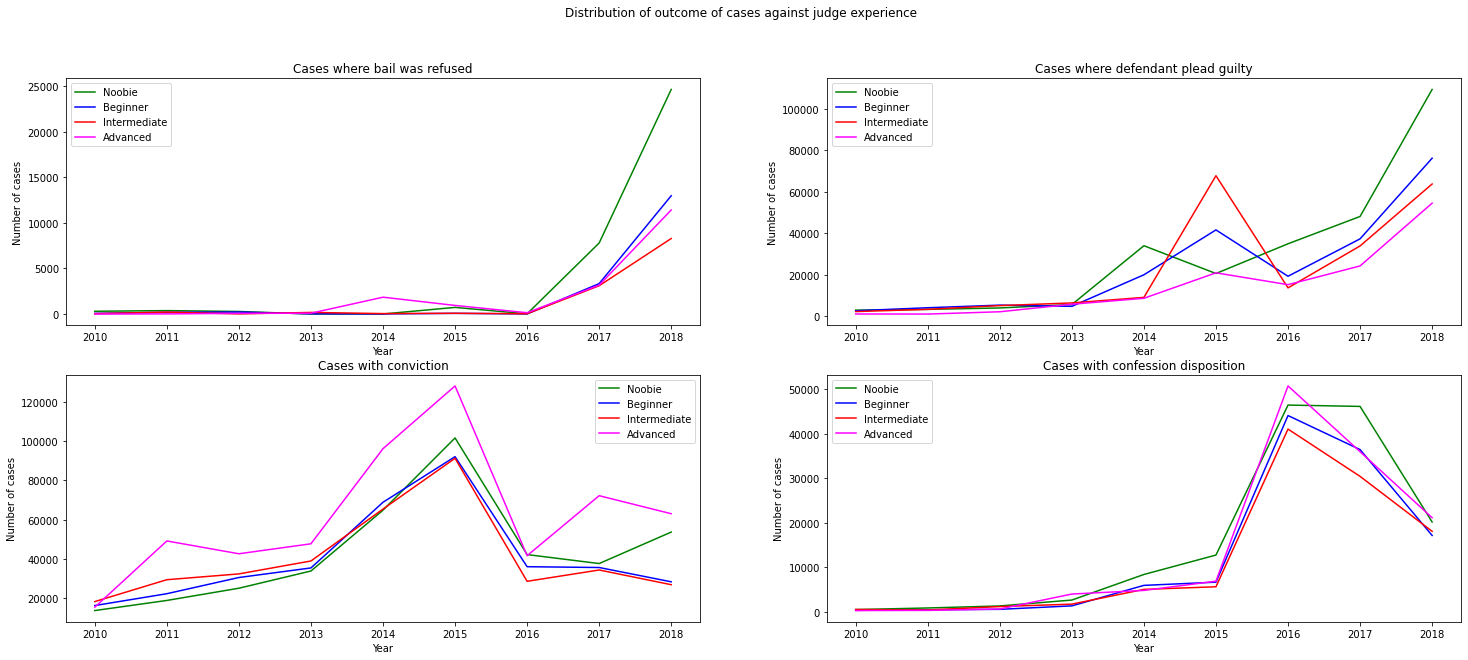

In [22]:
glob_x = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]
fig, axs = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(25)

fig.suptitle('Distribution of outcome of cases against judge experience')

y0_br = arr_bail_refused_np[0]
y1_br = arr_bail_refused_np[1]
y2_br = arr_bail_refused_np[2]
y3_br = arr_bail_refused_np[3]

axs[0,0].plot(glob_x, y0_br, label ='Noobie', color="green")
axs[0,0].plot(glob_x, y1_br, label ='Beginner', color="blue")
axs[0,0].plot(glob_x, y2_br, label ='Intermediate', color="red")
axs[0,0].plot(glob_x, y3_br, label ='Advanced', color="magenta")

axs[0,0].set_xlabel("Year")
axs[0,0].set_ylabel("Number of cases")
axs[0,0].legend()
axs[0,0].set_title('Cases where bail was refused')


y0_pg = arr_plead_guilty_np[0]
y1_pg = arr_plead_guilty_np[1]
y2_pg = arr_plead_guilty_np[2]
y3_pg = arr_plead_guilty_np[3]

axs[0,1].plot(glob_x, y0_pg, label ='Noobie', color="green")
axs[0,1].plot(glob_x, y1_pg, label ='Beginner', color="blue")
axs[0,1].plot(glob_x, y2_pg, label ='Intermediate', color="red")
axs[0,1].plot(glob_x, y3_pg, label ='Advanced', color="magenta")

axs[0,1].set_xlabel("Year")
axs[0,1].set_ylabel("Number of cases")
axs[0,1].legend()
axs[0,1].set_title('Cases where defendant plead guilty')

y0_conv = arr_convicted_np[0]
y1_conv = arr_convicted_np[1]
y2_conv = arr_convicted_np[2]
y3_conv = arr_convicted_np[3]

axs[1,0].plot(glob_x, y0_conv, label ='Noobie', color="green")
axs[1,0].plot(glob_x, y1_conv, label ='Beginner', color="blue")
axs[1,0].plot(glob_x, y2_conv, label ='Intermediate', color="red")
axs[1,0].plot(glob_x, y3_conv, label ='Advanced', color="magenta")

axs[1,0].set_xlabel("Year")
axs[1,0].set_ylabel("Number of cases")
axs[1,0].legend()
axs[1,0].set_title('Cases with conviction')


y0_conf = arr_confession_np[0]
y1_conf = arr_confession_np[1]
y2_conf = arr_confession_np[2]
y3_conf = arr_confession_np[3]

axs[1,1].plot(glob_x, y0_conf, label ='Noobie', color="green")
axs[1,1].plot(glob_x, y1_conf, label ='Beginner', color="blue")
axs[1,1].plot(glob_x, y2_conf, label ='Intermediate', color="red")
axs[1,1].plot(glob_x, y3_conf, label ='Advanced', color="magenta")

axs[1,1].set_xlabel("Year")
axs[1,1].set_ylabel("Number of cases")
axs[1,1].legend()
axs[1,1].set_title('Cases with confession disposition')


### The above graphs show some very interesting insights:
```
1. Confession Disposition seems to be equally distributed amongst judges.

2. Advanced judges are upto 2 times more likey to convict a defendant, and this trend remains consistent through years.

3. Noobie judges are upto two and half times more likey to refuse bail, a trend in recent years.

> Counterintuitive, but defendants more likey to plead guilty to newer judges. That is, the more experienced a judge is, the less likely a defendant is to plead guilty, with noobie and beginner judges experiencing upto 2 times more than thier intermediate and advanced counterparts.
---
```